In [1]:
%cd examples/bayes_hierarchical_model/
%load_ext autoreload
%autoreload 2

/home/vmu/nu_stats/examples/bayes_hierarchical_model


In [2]:
from astropy import units as u
import numpy as np

In [3]:
import sys
sys.path.append("../../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s
import warnings

In [4]:
# Simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
F_diff_norm = 1e-15 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [5]:
Nevents = [10*(2**i) for i in range(7)]
Nsims = len(Nevents)
sims=[Simulation(L, gamma, z, F_diff_norm = F_diff_norm,
    Emin=Emin, Emax=Emax, Enorm=Enorm, N_events=N)
    for N in Nevents]

In [6]:
for i in range(Nsims):
    sims[i].run(seed=i*10,verbose=True)
    if i>0:
        assert sims[i].truth == sims[i-1].truth
fit_inputs = [sim.get_data() for sim in sims]

Simulated 10 events
Simulated 20 events
Simulated 40 events
Simulated 80 events
Simulated 160 events
Simulated 320 events
Simulated 640 events


In [7]:
simtruef = sims[0].truth['f']

In [8]:
from nu_stats.fqutils import FqStructure
from nu_stats.bhmutils import BhStructure

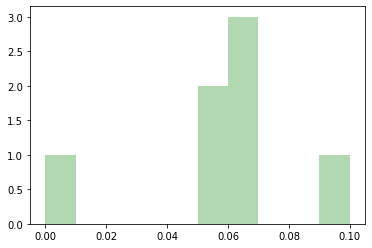

In [9]:
truenss = [sum(sim.labels==0) for sim in sims]
truensratios = [truenss[i]/Nevents[i] for i in range(Nsims)]
plt.hist(truensratios,
    color='g', alpha = .3)
plt.show()


In [10]:
truenss

[0, 2, 2, 5, 11, 19, 40]

In [11]:
fqs = [FqStructure(fit_input=f_i) for f_i in fit_inputs]
nhs = []
ghs = []
nhratios = []
ci_nhrs = []
ci_ghs = []
for i in range(Nsims):
    print(i)
    fqs[i].construct_diffuse_bg_energy_likelihood(
        fit_inputs[i]['z_bg'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
        Nbins=25, prefab_likelihood_file='tmp/False1.0_25lik.npy', verbose= False
    )
    fqs[i].construct_source_energy_likelihood(
        fit_inputs[i]['z'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
        Nbins=25, prefab_likelihood_file='tmp/True0.3_25lik.npy', verbose= False
    )
    _, nh, gh = fqs[i].minimize_neg_lbl()
    nhs.append(nh)
    ghs.append(gh)
    nhratios.append(nh/Nevents[i])

    # run Minos
    fqs[i].minuit.minos()
    if not fqs[i].minuit.merrors['n_s'].is_valid:
        print(f'WARNING: minos for n_s, sim {i} invalid')
    if not fqs[i].minuit.merrors['gamma'].is_valid:
        print(f'WARNING: minos for gamma, sim {i} invalid')
    ci_nhrs.append(((nh+fqs[i].minuit.merrors['n_s'].lower)/Nevents[i],
        (nh+fqs[i].minuit.merrors['n_s'].upper)/Nevents[i]))
    ci_ghs.append((gh+fqs[i].minuit.merrors['gamma'].lower,
        gh+fqs[i].minuit.merrors['gamma'].upper))

0
1
2
3
4
5
6


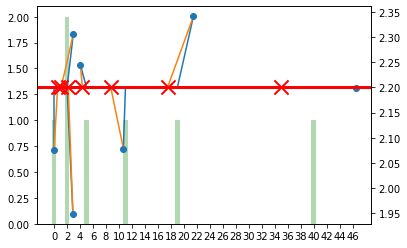

In [12]:
fig, axh = plt.subplots()

axh.hist(truenss, bins=np.arange(min(truenss)-1,max(truenss)+1)+.5,
    color='g', alpha = .3, histtype='barstacked', rwidth = 0.7, zorder = -20)

ax = axh.twinx()
for i in range(Nsims):
    plt.plot([nhs[i], truenss[i]], [ghs[i], gamma],c='C0', zorder=-10)
    plt.plot([nhs[i], sims[i].Nex_ps], [ghs[i], gamma],c='C1', zorder=-10)
plt.scatter(nhs,ghs)
plt.scatter([sim.Nex_ps for sim in sims], [sim.gamma for sim in sims], s=200 , marker='x', c='r', linewidths=2,
    label = r'True $(\bar{N}_s,\gamma)$')
ax.axhline(gamma, c='r', linewidth = 3)

plt.xticks(np.arange(np.floor(min(nhs)),
                     np.ceil(max(nhs)+1),
                     2))
fig.show()

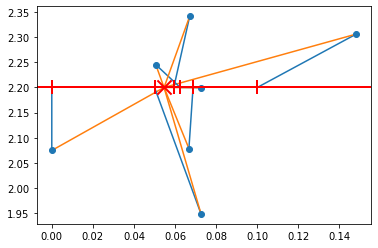

In [13]:
fig, ax = plt.subplots()

for i in range(Nsims):
    plt.plot([nhs[i]/Nevents[i], truenss[i]/Nevents[i]], [ghs[i], gamma],c='C0', zorder=-10)
    plt.plot([nhs[i]/Nevents[i], sims[i].truth['f']], [ghs[i], gamma],c='C1', zorder=-10)
plt.scatter([truenss[i]/Nevents[i] for i in range(Nsims)], [sim.gamma for sim in sims], s=200 , marker='+',
c='r', linewidths=2)
plt.scatter(nhratios,ghs)
plt.scatter(simtruef, gamma , s=200 , marker='x',
c='r', linewidths=2)
ax.axhline(gamma, c='r', linewidth = 2)

fig.show()

In [14]:
bhms = [BhStructure(f_i) for f_i in fit_inputs]

for i in range(Nsims):
    bhms[i].load_model("stan/toy_bhm.stan")
    bhms[i].run(seed=np.random.randint(10000000), num_chains = 10)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 7
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 8
INFO:cmdstanpy:finish chain 5
INFO:cmdstanpy:start chain 9
INFO:cmdstanpy:finish chain 6
INFO:cmdstanpy:start chain 10
INFO:cmdstanpy:finish chain 7
INFO:cmdstanpy:finish chain 8
INFO:cmdstanpy:finish chain 9
INFO:cmdstanpy:finish chain 10
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdsta

In [15]:
for i,bhm in enumerate(bhms):
    print(f'\n\n\n\nSim index {i}:')
    bhm.print_diagnostic()





Sim index 0:
INFO:cmdstanpy:Processing csv files: /tmp/tmp9eaif552/toy_bhm-202104191851-1-9ka23j6v.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-2-6gy1798w.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-3-pghk9zc9.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-4-o2g91fz7.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-5-qd9xpz_r.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-6-m86ataxy.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-7-9qinziff.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-8-1mylljz8.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-9-la8f2pt7.csv, /tmp/tmp9eaif552/toy_bhm-202104191851-10-sicg8t5a.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
2 of 10000 (0.02%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

C

# Plotting

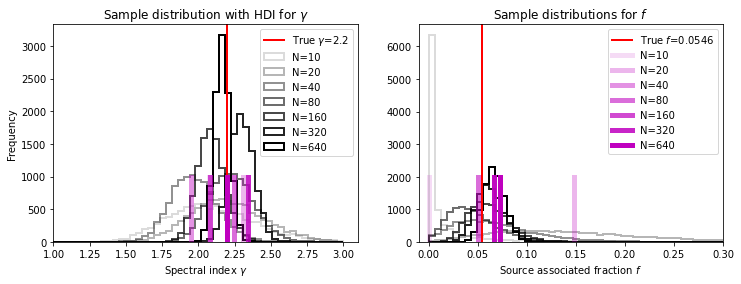

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].axvline(gamma,
    label=r'True $\gamma$'+f'={gamma:.3}',
    c='r', linewidth=2)
ax[1].axvline(simtruef,
    label=r'True $f$'+f'={simtruef:.3}',
    c='r', linewidth=2)

for i in range(Nsims):
    ax[0].hist(bhms[i].fit.stan_variable('gamma'),
        bins=np.linspace(1, 3, 50),
        # bins=20,
        histtype = 'step',
        linewidth = 2,
        alpha = (i+1)/Nsims,
        color = 'k',
        label = f'N={Nevents[i]}',
    )
    ax[0].axvline(min(ghs[i],3),0,0.3,linewidth = 5, c='m', alpha = (i+1)/Nsims)


    ax[1].hist(bhms[i].fit.stan_variable('f'),
        bins=np.linspace(0, .3, 50),
        # bins=20,
        histtype = 'step',
        linewidth = 2,
        alpha = (i+1)/Nsims,
        color = 'k',
    )
    ax[1].axvline(nhs[i]/Nevents[i],0,0.3,linewidth = 5, c='m', alpha = (i+1)/Nsims, label=f'N={Nevents[i]}')

ax[0].set_xlim((1.0,3.1))
ax[0].legend()
ax[0].set_xlabel('Spectral index $\gamma$')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Sample distribution with HDI for $\gamma$')

ax[1].set_xlim((-0.01,.3))
ax[1].legend()
ax[1].set_xlabel(r'Source associated fraction $f$')
ax[1].set_title(r'Sample distributions for $f$')

fig.set_size_inches((fig.get_size_inches()[0]*2,fig.get_size_inches()[1]))
fig.show()

In [17]:
from arviz import hdi

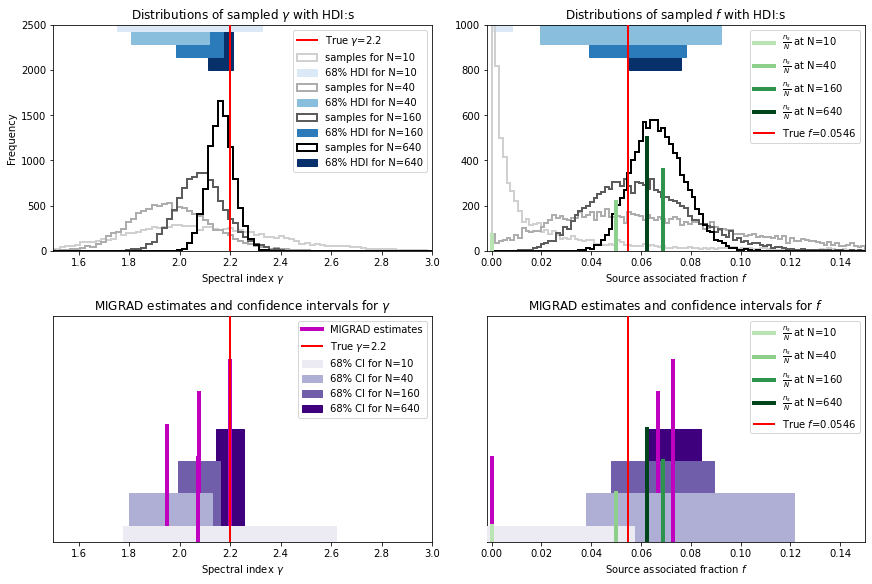

In [24]:
regions = True
skiphalf = True
halfagain = False

cmap = plt.get_cmap('Greys')
cmapfq = plt.get_cmap('Purples')
cmaphdi = plt.get_cmap('Blues')
cmapt = plt.get_cmap('Greens')

fig, ax = plt.subplots(2,2, constrained_layout=True)
postbins = 100
maxf = .15
credL = .68

for i in range(Nsims):
    if skiphalf and i%2: continue
    if halfagain and not (i//2)%2: continue
    _,_,patchesg = ax[0,0].hist(bhms[i].fit.stan_variable('gamma'),
        bins=np.linspace(1, 3, postbins),
        # bins=20,
        histtype = 'step',
        linewidth = 2,
        # color = 'k',
        color = cmap((i+1)/Nsims + (i==0)*0.15),
        label = f'samples for N={Nevents[i]}',
    )
    _,_,patchesf = ax[0,1].hist(bhms[i].fit.stan_variable('f'),
        bins=np.linspace(0, maxf, postbins),
        # bins=20,
        histtype = 'step',
        linewidth = 2,
        # color = 'k',
        color = cmap((i+1)/Nsims + (i==0)*0.15),
        #label = f'N={Nevents[i]}',
    )

    if regions:
        ax[0,0].axvspan(*hdi(bhms[i].fit.stan_variable('gamma'), hdi_prob=credL),
            .8 + .2*(Nsims-i-1)/Nsims, 1.0,
            # clip_path=patchesg[0],
            color=cmaphdi((i+1)/Nsims),
            zorder = -1e10+100*(Nsims-i),
            label = f'{int(credL*100)}% HDI for N={Nevents[i]}'
        )
        ax[0,1].axvspan(*hdi(bhms[i].fit.stan_variable('f'), hdi_prob=credL),
            .8 + .2*(Nsims-i-1)/Nsims, 1.0,
            # clip_path=patchesf[0],
            color=cmaphdi((i+1)/Nsims),
            zorder = -1e10+100*(Nsims-i),
        )
    #\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    if i:
        ax[1,0].axvline(min(ghs[i],3),0,0.5*(i+1)/Nsims+.3,
            linewidth = 4, c='m',
            zorder = 100*(Nsims-i)+1)
    else:
        ax[1,0].axvline(min(ghs[i],3),0,0.5*(i+1)/Nsims+.3,
            linewidth = 4, c='m',
            zorder = 100*(Nsims-i)+1,
            label = 'MIGRAD estimates'
            )
    ax[1,0].axvspan(*ci_ghs[i], 0, 0.5*(i+1)/Nsims,
        color=cmapfq((i+1)/Nsims),
        zorder = 100*(Nsims-i),
        label = f'68% CI for N={Nevents[i]}')

    ax[1,1].axvline(nhratios[i],0,0.5*(i+1)/Nsims+.3,
        linewidth = 4, c='m',
        zorder = 100*(Nsims-i)+1)
    ax[1,1].axvspan(*ci_nhrs[i], 0, 0.5*(i+1)/Nsims,
        color=cmapfq((i+1)/Nsims),
        zorder = 100*(Nsims-i),
    )

    for row in [0,1]:
        ax[row,1].axvline(truensratios[i],0, 0.5*(i+1)/Nsims,
            linewidth = 4, zorder = 1000*(Nsims-i),
            c=cmapt((i+1)/Nsims + (i==0)*0.15),
            label=r'$\frac{n_s}{N}$ '+f'at N={Nevents[i]}')

for i in [0,1]:
    ax[i,0].axvline(gamma,
        label=r'True $\gamma$'+f'={gamma:.3}',
        c='r', linewidth=2, zorder = 1e10)
    ax[i,1].axvline(simtruef,
        label=r'True $f$'+f'={simtruef:.3}',
        c='r', linewidth=2, zorder = 1e10)

    
    ax[i,0].set_xlim((1.5,3.0))
    ax[i,0].set_xlabel('Spectral index $\gamma$')
    ax[i,0].legend()
    ax[i,1].legend()
    ax[i,1].set_xlim((-0.002,maxf))
    ax[i,1].set_xlabel('Source associated fraction $f$')
    ax[1,i].axes.yaxis.set_visible(False)
ax[0,0].set_ylabel('Frequency')

ax[0,0].set_title('Distributions of sampled $\gamma$' + ' with HDI:s'*regions)
ax[0,1].set_title('Distributions of sampled $f$' + ' with HDI:s'*regions)

ax[1,0].set_title('MIGRAD estimates and confidence intervals for $\gamma$')
ax[1,1].set_title('MIGRAD estimates and confidence intervals for $f$')

ax[0,0].set_ylim((0,2500))
ax[0,1].set_ylim((0,1000))

fig.set_size_inches(*fig.get_size_inches()*2)
fig.show()